# Introduction

>
> 🎯**Objective:** The objective of this notebook is to find the patterns in the transactions and help algorithms learn those patterns in identifying the fradulent transactions and flag them
>
> 📌**Goals:**
>1. Exploratory analysis of data to extract the pattern of fraudlent activites
>2. Build a machine learning model to classify fraud and non-fraud transactions
>3. Reduce the false negatives by tuning the model

## 🤝 Libraries

In [1]:
#Basic libraries
import pandas as pd
import numpy as np

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

#ML libraries
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#Metrics Libraries
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

#Misc libraries
import warnings
warnings.filterwarnings("ignore")

# 🏧 Dataset
> Here we just import the dataset to see the overview of data
>
### Dataset description
1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
#Reading the data
df=pd.read_csv('Fraud.csv')

#Looking at the data
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [3]:
# Checking dataset overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Checking dataset shape
df.shape

(6362620, 11)

In [5]:
# Checking for null values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Checking for duplicate values
df.duplicated().sum()

0

# 📋 Pivot table analysis
>  Numbers is everything in transaction monitoring. Numbers decide whether it is a fraudulent activity or not. Let us look at the overall numbers using pivot table

In [4]:
#Pivot table
df_pivot1=pd.pivot_table(df,index=["type"],
                               values=['amount','isFraud','isFlaggedFraud'],
                               aggfunc=[np.sum], margins=True)

df_pivot1.style\
    .format('{:.2f}')\
    .bar(align='mid',color='lightblue')\
    .set_properties(padding='5px',border='3px solid white',width='200px')

---
<b>🔍Inference:</b> <br>
As per the current rule based algorithm, there has been no flags during fraud transactions incase of `CASH_OUT` , which is a serious concern. Also in `TRANSFER` there are only 16 transactions which are flagged as fraud whereas around 4k transactions are actually fraud. Our mission is now to build an efficient algorithm to mitigate this risk of letting fraud transactions unblocked<br>
<br>   

In [5]:
#Pivot table
df_pivot2=pd.pivot_table(df,index=["type"],
                               values=['amount','oldbalanceOrg','newbalanceOrig'],
                               aggfunc=[np.sum], margins=True)

#Adding style
df_pivot2.style\
    .format('{:.2f}')\
    .bar(align='mid',color='lightgrey')\
    .set_properties(padding='5px',border='3px solid white',width='200px')

---
<b>🔍Inference:</b> <br>
From the table we can understand that most of the customers use the system for transfering money and we have a relatively less data for payments made. Also it is quite interesting to notice the difference between the new and old balance as it tells us some stories. Here we have only the visuals of `Orig` account and cash balance have reduced in all cases except `CASH_IN` . Even in `TRANSFER` the balance have reduced which shows that we have more sender information in Original account<br>
<br>   

In [6]:
#Pivot table
df_pivot3=pd.pivot_table(df,index=["type"],
                               values=['amount','oldbalanceDest','newbalanceDest'],
                               aggfunc=[np.sum], margins=True)

#Adding style
df_pivot3.style\
    .format('{:.2f}')\
    .bar(align='mid',color='lightgreen')\
    .set_properties(padding='5px',border='3px solid white',width='200px')

---
<b>🔍Inference:</b> <br>
In this table we have the information of destination account , from the `TRANSFER` information we can see the increase in new balance, hence this is the receiver's info. There is no payment amount available for `Dest` information.<br>
<br>   


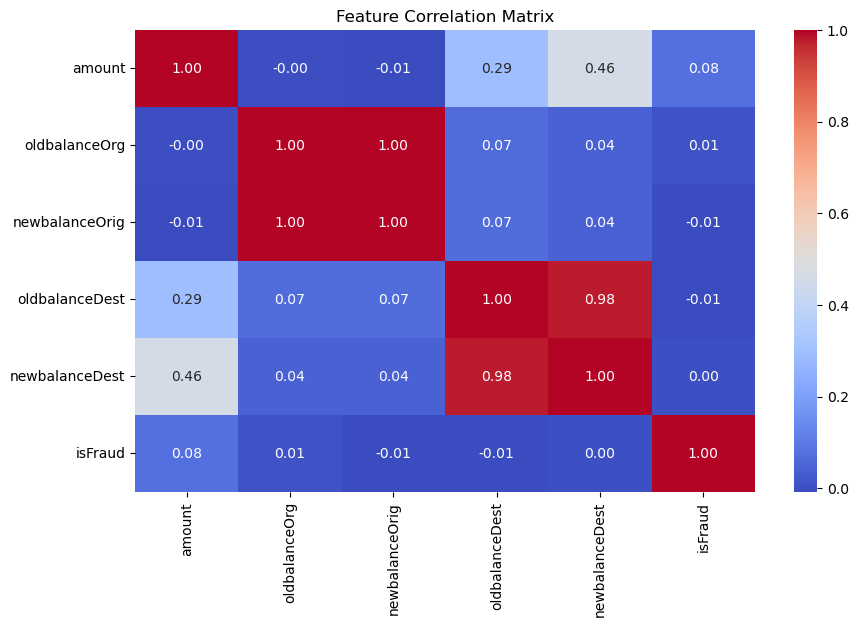

In [7]:
# Creating correlation matrix
corr_matrix = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

---
<b>🔍Inference:</b> <br>
The correlation matrix shows that `oldbalanceOrg` and `newbalanceOrig` are highly correlated, as well as `oldbalanceDest` and `newbalanceDest`, indicating redundancy. The weak correlation of features with `isFraud` suggests that these alone may not be strong fraud predictors.<br>
<br>   


## 📊 Distribution of Amount
>  It is important to understand the distribution of our data, since it can play a major role in model building and also in understanding our data. Going forward we will be using only 200k rows as it takes a lot of time to process all the records for viz and model building.
> Here we check for the distribution of amount transacted using the application

In [8]:
#Reading the first 200000 rows
df_1 =pd.read_csv('Fraud.csv',nrows=200000)

#Distribution of Amount
fig = px.box(data_frame=df_1, y="amount")
fig.show()

---
<b>🔍Inference:</b> <br>
From the bar plot we can understand that we have a very right skewed dataset, there are a lot of outliers which goes upto 10M with a median of around 68k. The upper bracket(75th percentile) counts upto 550k<br>
<br>   


# 🔧 Feature engineering
>  Time to get our hands dirty with feature engineering. With the available information it is hard to train the model and get better results. Hence we move onto create new features by altering the existing features. In this we create three functions which creates a highly relevant feature for the domain
>
> 1. **Difference in balance:** It is an universal truth that the amount debited from senders account gets credited into the receivers account without any deviation in cents. But what if there is a deviation incase of the amount debited and credited. Some could be due to the charges levied by the service providers, yet we need to flag such unusual instances
> 2. **Surge indicator:** Also we have to trigger flag when large amount are involved in the transaction. From the distribution of amount we understood that we have a lot of outliers with high amount in transactions. Hence we consider the 75th percentile(550k) as our threshold and amount which is greater than 550k will be triggered as a flag
> 3. **Frequency indicator:** Here we flag the user and not the transaction. When there is a receiver who receives money from a lot of people, it could be a trigger as it can be for some illegal games of chance or luck. Hence it is flagged when there is a receiver who receives money for more than 20 times.
>4. **Merchant indicator:** The customer ids in receiver starts with 'M' which means that they are merchants and they obviously will have a lot of receiving transactions. So we also flag whenever there is a merchant receiver

In [9]:
# Creating New fields 

def Feature_Engineering(data):

      # Difference in balance
      '''balance_diff checks whether the money debited from sender has exactly credited to the receiver
          then it creates a new column which indicates 1 when there is a deviation else 0
      '''
      #Sender's balance
      orig_change = np.abs(data['newbalanceOrig'] - data['oldbalanceOrg']).astype(int)
      data['orig_txn_diff']=round(data['amount']- orig_change,2).astype(int)
      data['orig_diff'] = [1 if n !=0 else 0 for n in data['orig_txn_diff']]
    
      #Receiver's balance
      dest_change=np.abs(data['newbalanceDest']-data['oldbalanceDest']).astype(int)
      data['dest_txn_diff']=round(data['amount'] - dest_change,2).astype(int)
      data['dest_diff'] = [1 if n !=0 else 0 for n in data['dest_txn_diff']]
    
      data.drop(['orig_txn_diff','dest_txn_diff'],axis=1,inplace = True)
    
    #Surge indicator
      '''Creates a new column which has 1 if the transaction amount is greater than the threshold else it will be 0'''
      data['surge']=[1 if n>550000 else 0 for n in data['amount']]
    
    #Frequency indicator
      '''Creates a new column which has 1 if the receiver receives money from many individuals
        else it will be 0'''
      data['freq_Dest']=data['nameDest'].map(data['nameDest'].value_counts())
      data['freq_dest']=[1 if n>20 else 0 for n in data['freq_Dest']]
    
      data.drop(['freq_Dest'],axis=1,inplace = True)
    
    #Tracking the receiver as merchant or not
      '''We also have customer ids which starts with M in Receiver name, it indicates merchant 
      this function will flag if there is a merchant in receiver end '''
      values = ['M']
      conditions = list(map(data['nameDest'].str.contains, values))
      data['merchant'] = np.select(conditions, '1', '0').astype(int)

In [10]:
# Applying Feature_Engineering
Feature_Engineering(df_1)

# ⚙️ Pre-processing data
>  Before moving to build a machine learning model, it is mandatory to pre-process the data so that the model trains without any error and can learn better to provide better results


## 1. One hot encoding
> One of the most important feature we have is type which is categorical in type. Since it doesnt have any ordinal nature and since the classes are less, we prefer applying one hot encoding.

In [11]:
#Encode Categorical Columns
encoder = LabelEncoder()
df_1['type'] = encoder.fit_transform(df_1['type'])
df_1.head()

step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     3   9839.64  C1231006815       170136.0       160296.36   
1     1     3   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     3  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   orig_diff  dest_diff  surge  freq_dest  merchant  
0          0          1      0          0         1  
1          0          1      0          0         1  
2          0          1      0          0         0  
3          0          1      0          0         0  
4          0          1      0          0         1

## 2. Dropping unnecessary columns
> We dont need the sender and receiver nameID as well as oldbalanceOrg and oldbalanceDest as they are correlated, also we dont required isFlaggedFraud as it is just an outcome of previous tested algorithm.

In [12]:
#Dropping unnecessary columns
df_1=df_1.drop(['nameOrig','nameDest','oldbalanceOrg', 'oldbalanceDest', 'isFlaggedFraud'],axis=1)
df_1 = df_1.reset_index(drop=True)

## 3. Split and Standardize
> In this module we create the independent and dependent feature, then split them into train and test data where training size is 70%. Later we collect all the numerical features and apply StandardScaler() function which transforms the distribution so that the mean becomes 0 and standard deviation becomes 1

In [13]:
#Splitting dependent and independent variable
X=df_1.drop('isFraud',axis=1)
y=df_1['isFraud']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=111)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## 4. Balancing the target
> From the pie chart below we can clearly see that the target label is heavily imbalance with less than 0.1% of fraudulent data which is in-sufficient for machine to learn and flag when fraud transactions happen.

In [14]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=y_train.value_counts())])
fig.show()

In [15]:
# Applying SMOTE for Imbalanced Data
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [16]:
# Now again checking the balanced target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=y_resampled.value_counts())])
fig.show()

# 🤖 Choosing ML Model
> We have successfully processed the data and it is time for serving the data to the model. It is time consuming to find out which model works best for our data. Hence I have utlized pipeline to run our data through all the classification algorithm and select the best which gives out the maximum accuracy.

In [20]:
# Utility fucntion
def confusion_plot(cm):

  # labels
  labels = ["No Fraud", "Fraud"]

  # confusion matrix heatmap
  plt.figure(figsize=(4,3))
  sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [21]:
# Creating a dictionary of models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(kernel='linear', max_iter=500, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(criterion="log_loss", random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42)
}

# List to store results
results_list = []

# Evaluate each model using cross-validation
for model_name, model in models.items():
    accuracy = cross_val_score(model, X_resampled,y_resampled, cv=10, scoring='accuracy').mean()
    print(f"{model_name:<25} : {accuracy}")
    results_list.append({'Model': model_name, 'Training Accuracy': accuracy})

Logistic Regression       : 0.9788533562509574
K-Nearest Neighbors       : 0.998209487424314
Support Vector Machine    : 0.7357836093158181
Naive Bayes               : 0.9870232440224997
Random Forest             : 0.9999857044575254
XGBoost                   : 0.9999142267451525


In [23]:
# results to a DataFrame
results = pd.DataFrame(results_list)

# Sort results by Accuracy (Descending Order)
results = results.sort_values(by='Training Accuracy', ascending=False).reset_index(drop=True)
results

Model  Training Accuracy
0           Random Forest           0.999986
1                 XGBoost           0.999914
2     K-Nearest Neighbors           0.998209
3             Naive Bayes           0.987023
4     Logistic Regression           0.978853
5  Support Vector Machine           0.735784

---
<b>💭Thoughts:</b> <br>
Random Forest and XGBoost achieved near-perfect accuracy, indicating possible overfitting. KNN and Naive Bayes also performed well, while SVM struggled. Before moving to any conclusions, we should validate on unseen test data. 🚀<br>
<br>   


# 🧪 Evaluation of model
> Time to explore the truth of high numbers by evaluating against validation data


📊 Classification Report for Random Forest on Validation data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59949
           1       0.98      0.86      0.92        51

    accuracy                           1.00     60000
   macro avg       0.99      0.93      0.96     60000
weighted avg       1.00      1.00      1.00     60000



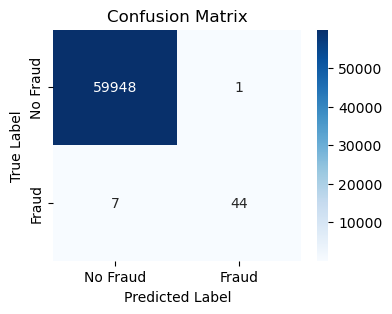

In [24]:
# Running our best model
model = RandomForestClassifier(criterion="log_loss", n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

# Validating our model
y_pred = model.predict(X_val)
    
# Classification Report
print(f"\n📊 Classification Report for Random Forest on Validation data:\n")
print(classification_report(y_val, y_pred))
    
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
confusion_plot(cm)

---
<b>💭Thoughts:</b> <br>
Random Forest performed exceptionally well with near-perfect accuracy. However, it missed some fraud cases, so improving recall could make the model even better. But, for now we will use this as it is.<br>
<br>   

# 🧪 Testing of our model
> Time to explore the truth of high numbers by evaluating against unseen test data

In [25]:
# Load the dataset
data = pd.read_csv('Fraud.csv')

# Taking a random sample of 100,000 rows
data = data.sample(n=100000, random_state=42)

# Split into test data and test labels
test_data = data.drop('isFraud', axis=1)
test_label = data['isFraud']

#Applying Feature Engineering
Feature_Engineering(test_data)

#Encoding
test_data['type'] = encoder.fit_transform(test_data['type'])

#Dropping unnecessary columns
test_data=test_data.drop(['nameOrig','nameDest','oldbalanceOrg', 'oldbalanceDest', 'isFlaggedFraud'],axis=1)
test_data = test_data.reset_index(drop=True)

# Scaling
test_data = scaler.transform(test_data)


📊 Classification Report for Random Forest on Unseen data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99859
           1       0.99      0.98      0.99       141

    accuracy                           1.00    100000
   macro avg       1.00      0.99      0.99    100000
weighted avg       1.00      1.00      1.00    100000



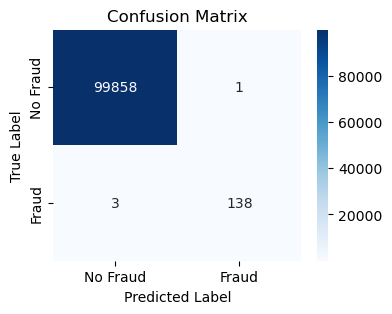

In [26]:
# Predicting on unseen data
y_pred = model.predict(test_data)

# Classification Report
print(f"\n📊 Classification Report for Random Forest on Unseen data:\n")
print(classification_report(test_label, y_pred))
    
# Confusion Matrix
cm = confusion_matrix(test_label, y_pred)
confusion_plot(cm)

---
<b>💭Thoughts:</b> <br>
When we found that our false negatives are more important than false positives, we have to look at the recall number and we have around 98% recall efficiency in finding the fraud transactions and 100% precision in finding the non fraud tranactions and on an average our model performs exceptionally well with overall accuracy close to 100%.<br>
<br>   